## Stock Market Forecasting

Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process.
- https://medium.com/@himamohamed9688/stock-market-forecasting-ca11884ceb8c

In [3]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pandas_datareader import data as web


matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

We are going to do time series analysis and forecasting for stock market.

In [4]:
df1 = pd.read_csv('Apple.csv')
df2= pd.read_csv('amazon.csv')
df3 = pd.read_csv('TSLA.csv')
stock=df3

In [5]:
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [6]:
stock['Date'].min()

'2010-06-29'

In [7]:
stock['Date'].max()

'2022-03-18'

In [8]:
#stock['Date']=pd.to_datetime(df.Date,format='%Y%m%d', errors='ignore')

In [9]:
stock.Date = pd.to_datetime(stock.Date, format='%Y%m%d', errors='ignore')

## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [10]:
cols = ['High', 'Low', 'Open', 'Volume', 'Adj Close']
stock.drop(cols, axis=1, inplace=True) #needs to be inplace otherwise won't mutate the stock object
stock = stock.sort_values('Date')
type(stock)

pandas.core.frame.DataFrame

In [11]:
stock.isnull().sum()

Date     0
Close    0
dtype: int64

In [12]:
stock

,Date,Close
0,2010-06-29,4.778000
1,2010-06-30,4.766000
2,2010-07-01,4.392000
3,2010-07-02,3.840000
4,2010-07-06,3.222000
...,...,...
2948,2022-03-15,801.890015
2949,2022-03-16,840.229980
2950,2022-03-17,871.599976
2951,2022-03-18,905.390015


In [13]:
stock = stock.groupby('Date')['Close'].sum().reset_index()
stock

,Date,Close
0,2010-06-29,4.778000
1,2010-06-30,4.766000
2,2010-07-01,4.392000
3,2010-07-02,3.840000
4,2010-07-06,3.222000
...,...,...
2947,2022-03-14,766.369995
2948,2022-03-15,801.890015
2949,2022-03-16,840.229980
2950,2022-03-17,871.599976


In [14]:
stock.head()

,Date,Close
0,2010-06-29,4.778
1,2010-06-30,4.766
2,2010-07-01,4.392
3,2010-07-02,3.840
4,2010-07-06,3.222


## Indexing with time series data

In [15]:
stock = stock.set_index('Date')
stock.index


Index(['2010-06-29', '2010-06-30', '2010-07-01', '2010-07-02', '2010-07-06',
       '2010-07-07', '2010-07-08', '2010-07-09', '2010-07-12', '2010-07-13',
       ...
       '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10', '2022-03-11',
       '2022-03-14', '2022-03-15', '2022-03-16', '2022-03-17', '2022-03-18'],
      dtype='object', name='Date', length=2952)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [16]:
#y = stock['Close'].resample('M').mean()
stock.index = pd.to_datetime(stock.index)

monthly_mean = stock.Close.resample('M').mean()
monthly_mean

Date
2010-06-30       4.772000
2010-07-31       3.911619
2010-08-31       3.902182
2010-09-30       4.148095
2010-10-31       4.142667
                 ...     
2021-11-30    1120.662383
2021-12-31    1018.889990
2022-01-31    1010.168497
2022-02-28     878.884737
2022-03-31     902.450710
Freq: M, Name: Close, Length: 142, dtype: float64

Have a quick peek 2017 sales data.

In [17]:
monthly_mean['2022':]

Date
2022-01-31    1010.168497
2022-02-28     878.884737
2022-03-31     902.450710
Freq: M, Name: Close, dtype: float64

## Visualizing Close time series data

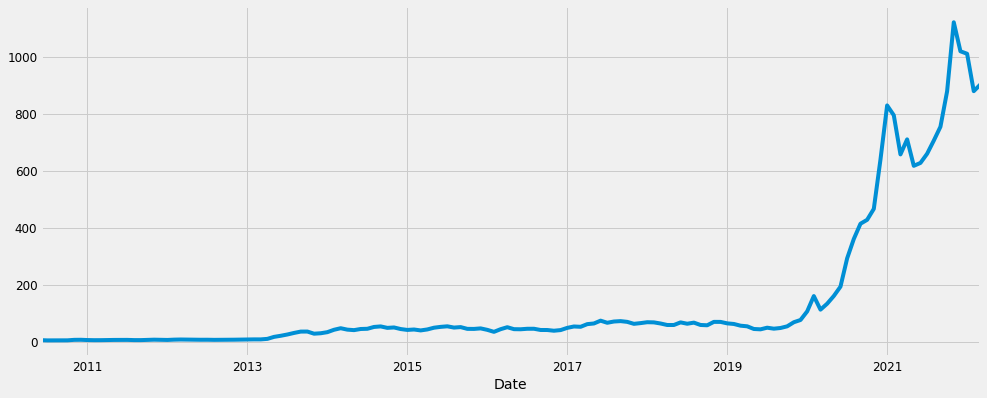

In [18]:
monthly_mean.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

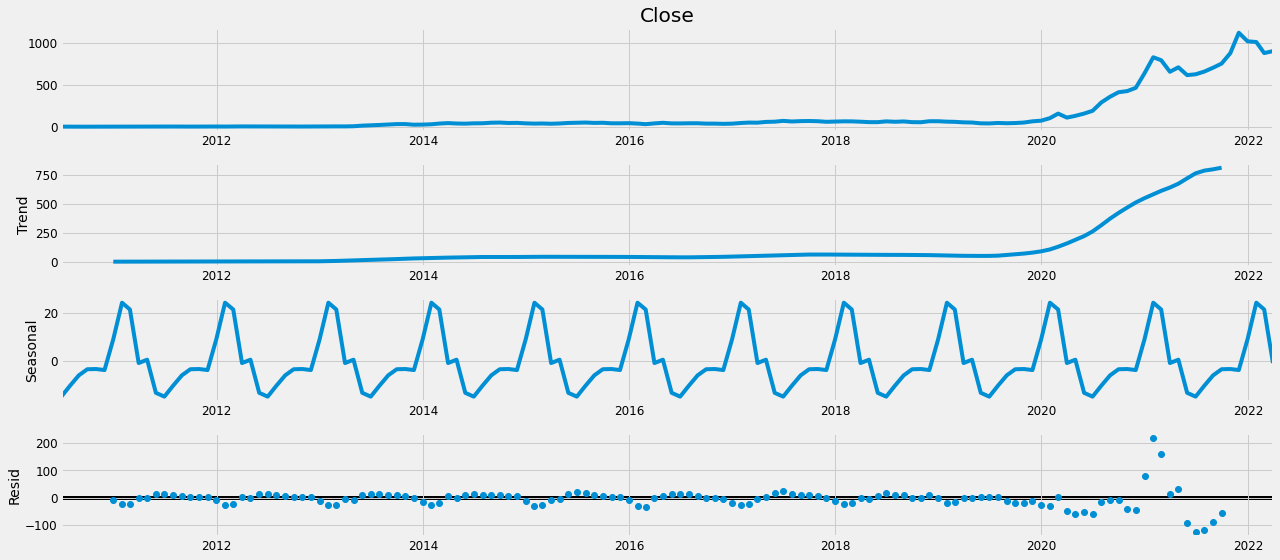

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the Close price is unstable, along with its obvious seasonality.

## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model. ARIMA models are denoted with the notation `ARIMA(p, d, q)`. These three parameters account for seasonality, trend, and noise in data:`

In [20]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
print('pdq =', pdq)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('seasonal_pdq ', seasonal_pdq)

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

pdq = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
seasonal_pdq  [(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]
Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [21]:
l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1999.5673100768145
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1756.0592477084638
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1708.0727403115297
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1525.1661365082668
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1670.1269797051282
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1637.6515256806547
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1539.3259080834764
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1526.9463199616991
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1812.7187117764445
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1585.7384981145551
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1539.379768789789
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1370.8251873781517
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1515.7629162485846
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1486.375537170672
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1397.7192411535218
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1372.8163541864901
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1439.0176217514118
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1328.50931182

In [22]:
print(l_results_aic)
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

[1999.5673100768145, 1756.0592477084638, 1708.0727403115297, 1525.1661365082668, 1670.1269797051282, 1637.6515256806547, 1539.3259080834764, 1526.9463199616991, 1812.7187117764445, 1585.7384981145551, 1539.379768789789, 1370.8251873781517, 1515.7629162485846, 1486.375537170672, 1397.7192411535218, 1372.8163541864901, 1439.0176217514118, 1328.5093118277102, 1368.294352613561, 1222.22945367676, 1337.797677500632, 1330.4409845795105, 1233.1887266932938, 1223.0097318776807, 1424.9954580579029, 1315.4187737147158, 1351.1777085960803, 1210.0647645392576, 1334.0275017217152, 1317.3869514632229, 1231.2752950286786, 1210.9796195744082, 1445.597792342316, 1336.3678029659723, 1378.2773348933517, 1265.3113177182165, 1336.3667936892282, 1338.3665338589417, 1234.0037903490622, 1237.406486428712, 1433.6083365144173, 1324.9464775968431, 1359.981334336696, 1268.5567839420019, 1333.9905490460924, 1326.707790022645, 1232.7338653515792, 1270.5561609353356, 1433.3751739440931, 1324.220034627624, 1364.94387

In [23]:
mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2032      0.070      2.898      0.004       0.066       0.341
ma.S.L12      -0.7319      0.103     -7.116      0.000      -0.933      -0.530
sigma2      1995.3407    131.415     15.183      0.000    1737.771    2252.910


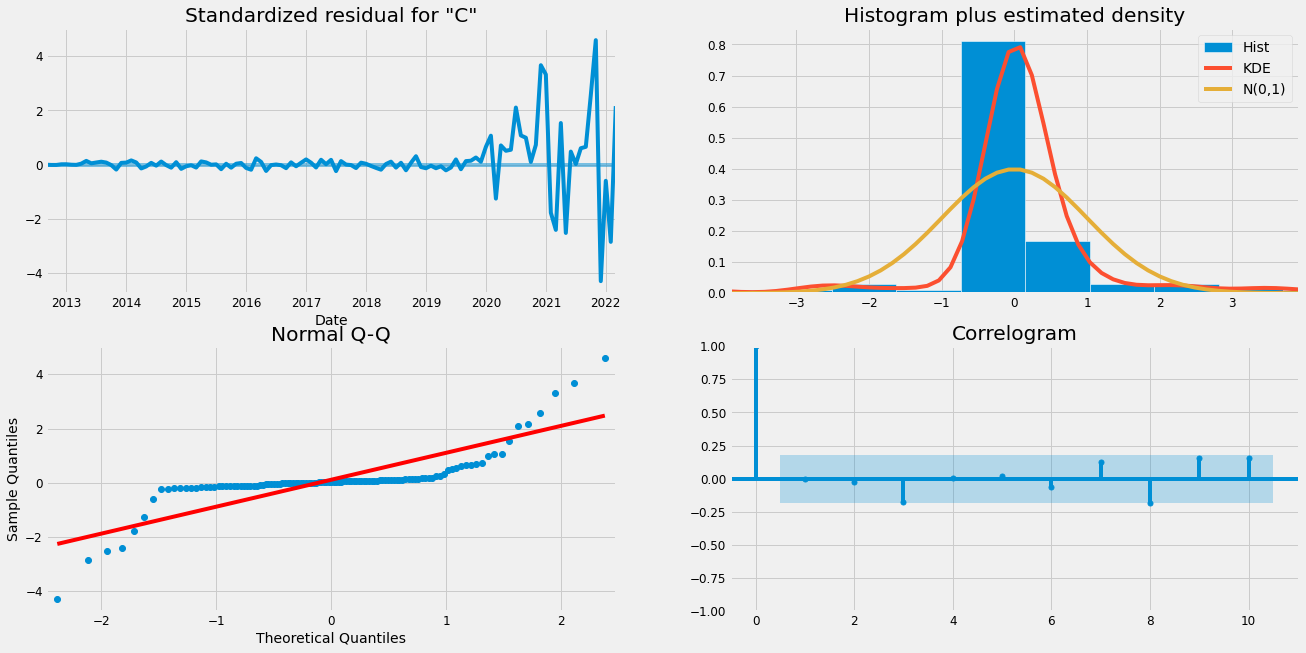

In [24]:
results.plot_diagnostics(figsize=(20, 10))
plt.show()

## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted Close to real close price of the time series, and we set forecasts to start at `2017-12-31` to the end of the data.

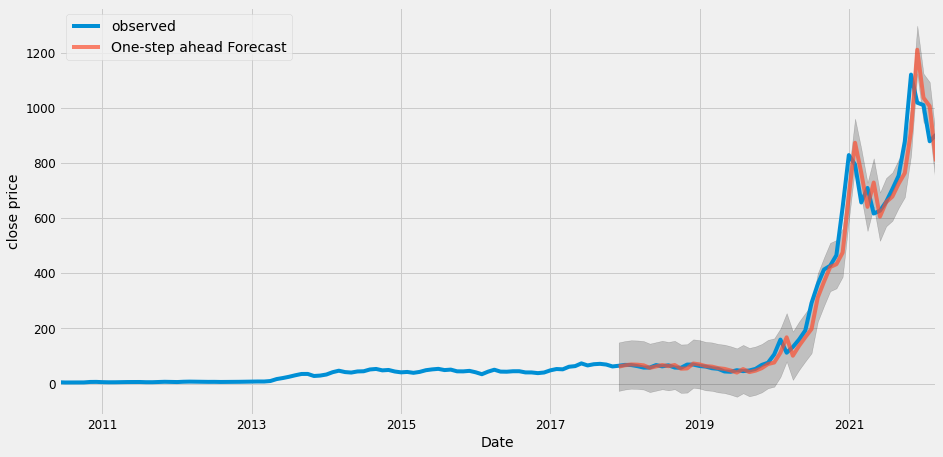

In [25]:
pred = results.get_prediction(start=pd.to_datetime('2017-12-31'), dynamic=False) # prediction start date
pred_ci = pred.conf_int()

ax = monthly_mean['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

In [26]:
y_forecasted = pred.predicted_mean
y_truth = monthly_mean['2017-12-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4388.93


In [27]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 66.25


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily close price in the test set within portion... of the real close price.

## Calculating the Roy Ratio for past
Since the stock prices differ greatly, we cannot just use the absolute value of the mean sqaured error to compare volatility between stocks. Thus, we use something we call the Roy ratio which is equal to the predicted value divided by the volatile range.

In [28]:
actual=pd.DataFrame(monthly_mean['2017-12-31':'2022-03-31'])

result = pd.concat([pred_ci, actual], axis=1).reindex(pred_ci.index)
display(result)

,lower Close,upper Close,Close
Date,,,
2017-12-31,-26.555853,149.064486,64.568201
2018-01-31,-21.584674,154.035665,67.716666
2018-02-28,-18.560382,157.059957,67.155474
2018-03-31,-19.291159,156.329180,63.196666
2018-04-30,-21.578813,154.041526,57.954572
2018-05-31,-30.914902,144.705435,57.970455
2018-06-30,-25.681712,149.938568,67.120095
2018-07-31,-20.553222,155.056889,62.394952
2018-08-31,-24.598205,150.788745,66.242869


In [29]:
print(pred_ci)
volatility = (pred_ci['upper Close']-pred_ci['lower Close'])/(pred_ci['upper Close']+pred_ci['lower Close'])*2

            lower Close  upper Close
Date                                
2017-12-31   -26.555853   149.064486
2018-01-31   -21.584674   154.035665
2018-02-28   -18.560382   157.059957
2018-03-31   -19.291159   156.329180
2018-04-30   -21.578813   154.041526
2018-05-31   -30.914902   144.705435
2018-06-30   -25.681712   149.938568
2018-07-31   -20.553222   155.056889
2018-08-31   -24.598205   150.788745
2018-09-30   -20.410590   154.967177
2018-10-31   -33.742940   141.634447
2018-11-30   -32.781775   142.595597
2018-12-31   -14.996120   160.381251
2019-01-31   -18.079656   157.297715
2019-02-28   -24.448570   150.928802
2019-03-31   -26.264057   149.113314
2019-04-30   -31.763875   143.613496
2019-05-31   -34.427343   140.950027
2019-06-30   -40.280080   135.097260
2019-07-31   -47.821490   127.550444
2019-08-31   -35.133282   140.120071
2019-09-30   -46.054035   129.194433
2019-10-31   -40.863905   134.384361
2019-11-30   -31.791004   143.457254
2019-12-31   -16.888442   158.359816
2

In [30]:
volatility

Date
2017-12-31    2.867069
2018-01-31    2.651854
2018-02-28    2.536042
2018-03-31    2.563089
2018-04-30    2.651619
2018-05-31    3.086730
2018-06-30    2.826730
2018-07-31    2.611232
2018-08-31    2.779716
2018-09-30    2.606751
2018-10-31    3.250995
2018-11-30    3.194086
2018-12-31    2.412590
2019-01-31    2.519463
2019-02-28    2.773198
2019-03-31    2.855164
2019-04-30    3.135949
2019-05-31    3.292770
2019-06-30    3.699273
2019-07-31    4.399203
2019-08-31    3.338579
2019-09-30    4.215724
2019-10-31    3.747806
2019-11-30    3.138786
2019-12-31    2.477508
2020-01-31    2.297502
2020-02-29    1.569259
2020-03-31    1.044720
2020-04-30    1.735142
2020-05-31    1.279559
2020-06-30    1.042346
2020-07-31    0.885768
2020-08-31    0.561701
2020-09-30    0.474622
2020-10-31    0.414424
2020-11-30    0.404660
2020-12-31    0.368898
2021-01-31    0.257583
2021-02-28    0.200563
2021-03-31    0.229209
2021-04-30    0.273295
2021-05-31    0.240213
2021-06-30    0.289385
2021-0

In [31]:
roy_ratio=((pred_ci['upper Close']+pred_ci['lower Close'])/2 )/(-pred_ci['lower Close']+pred_ci['upper Close'])
roy_ratio # predicted_mean/volatility around mean

Date
2017-12-31    0.348788
2018-01-31    0.377095
2018-02-28    0.394315
2018-03-31    0.390154
2018-04-30    0.377128
2018-05-31    0.323967
2018-06-30    0.353766
2018-07-31    0.382961
2018-08-31    0.359749
2018-09-30    0.383619
2018-10-31    0.307598
2018-11-30    0.313079
2018-12-31    0.414492
2019-01-31    0.396910
2019-02-28    0.360595
2019-03-31    0.350243
2019-04-30    0.318883
2019-05-31    0.303696
2019-06-30    0.270323
2019-07-31    0.227314
2019-08-31    0.299529
2019-09-30    0.237207
2019-10-31    0.266823
2019-11-30    0.318594
2019-12-31    0.403631
2020-01-31    0.435255
2020-02-29    0.637243
2020-03-31    0.957194
2020-04-30    0.576322
2020-05-31    0.781520
2020-06-30    0.959374
2020-07-31    1.128964
2020-08-31    1.780308
2020-09-30    2.106940
2020-10-31    2.412987
2020-11-30    2.471213
2020-12-31    2.710774
2021-01-31    3.882245
2021-02-28    4.985958
2021-03-31    4.362839
2021-04-30    3.659048
2021-05-31    4.162978
2021-06-30    3.455608
2021-0

## Producing and visualizing forecasts

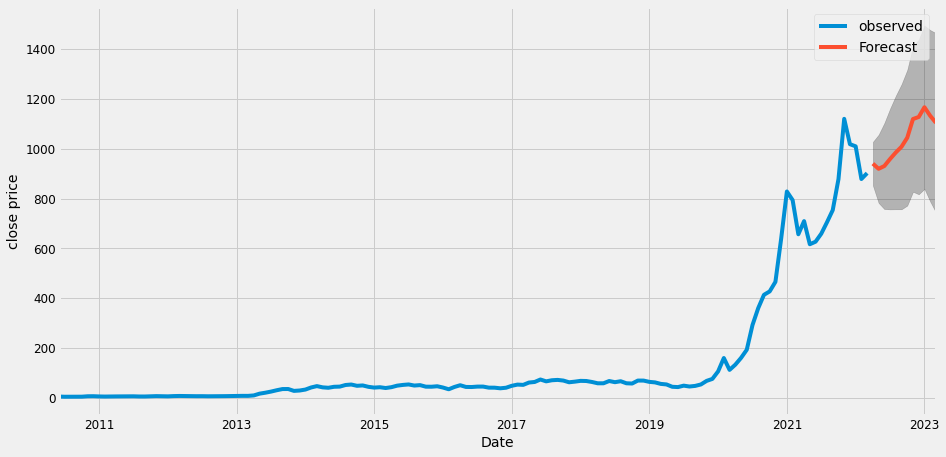

In [32]:
pred_uc = results.get_forecast(steps=12) # each step is 1 month. 12 to predict 1 year
pred_ci = pred_uc.conf_int()

ax = monthly_mean.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('close price')

plt.legend()
plt.show()

Our model clearly captured close price seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

## Calculating roy Ratio for Future allocation

In [33]:
roy_ratio_future_tesla=((pred_ci['upper Close']+pred_ci['lower Close'])/2 )/(pred_ci['upper Close']-pred_ci['lower Close'])
roy_ratio_future_tesla # predicted_mean/volatility around mean



2022-04-30    5.370838
2022-05-31    3.357082
2022-06-30    2.693276
2022-07-31    2.369522
2022-08-31    2.159158
2022-09-30    2.006430
2022-10-31    1.916843
2022-11-30    1.916511
2022-12-31    1.815982
2023-01-31    1.779600
2023-02-28    1.644552
2023-03-31    1.533593
Freq: M, dtype: float64

# Repeating for AAPL

In [34]:
stock2=(web.DataReader("AAPL", data_source='yahoo', start = '2010-06-29', end = '2022-03-18'))['Close']
stock2=pd.DataFrame(stock2)
stock2 = stock2.sort_values('Date')
type(stock2)


stock2.isnull().sum()

stock2

stock2 = stock2.groupby('Date')['Close'].sum().reset_index()
stock2
stock2.head()


,Date,Close
0,2010-06-28,9.582143
1,2010-06-29,9.148929
2,2010-06-30,8.983214
3,2010-07-01,8.874286
4,2010-07-02,8.819286


In [35]:
stock2.Date = pd.to_datetime(stock2.Date, format='%Y%m%d', errors='ignore')

In [36]:
stock2

,Date,Close
0,2010-06-28,9.582143
1,2010-06-29,9.148929
2,2010-06-30,8.983214
3,2010-07-01,8.874286
4,2010-07-02,8.819286
...,...,...
2948,2022-03-14,150.619995
2949,2022-03-15,155.089996
2950,2022-03-16,159.589996
2951,2022-03-17,160.619995


In [37]:
stock2 = stock2.set_index('Date')
stock2.index

DatetimeIndex(['2010-06-28', '2010-06-29', '2010-06-30', '2010-07-01',
               '2010-07-02', '2010-07-06', '2010-07-07', '2010-07-08',
               '2010-07-09', '2010-07-12',
               ...
               '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10',
               '2022-03-11', '2022-03-14', '2022-03-15', '2022-03-16',
               '2022-03-17', '2022-03-18'],
              dtype='datetime64[ns]', name='Date', length=2953, freq=None)

In [38]:
display(stock2)
stock2.index = pd.to_datetime(stock2.index)

monthly_mean2 = stock2.Close.resample('M').mean()



,Close
Date,
2010-06-28,9.582143
2010-06-29,9.148929
2010-06-30,8.983214
2010-07-01,8.874286
2010-07-02,8.819286
...,...
2022-03-14,150.619995
2022-03-15,155.089996
2022-03-16,159.589996


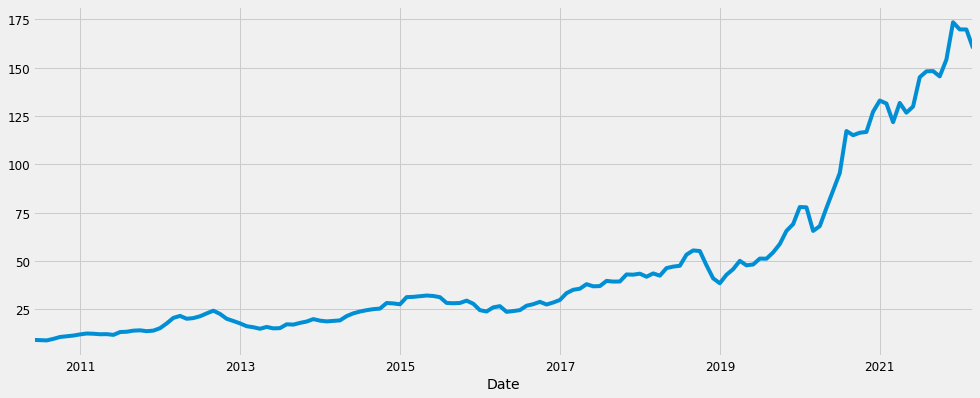

In [39]:
monthly_mean2.plot(figsize=(15, 6))
plt.show()

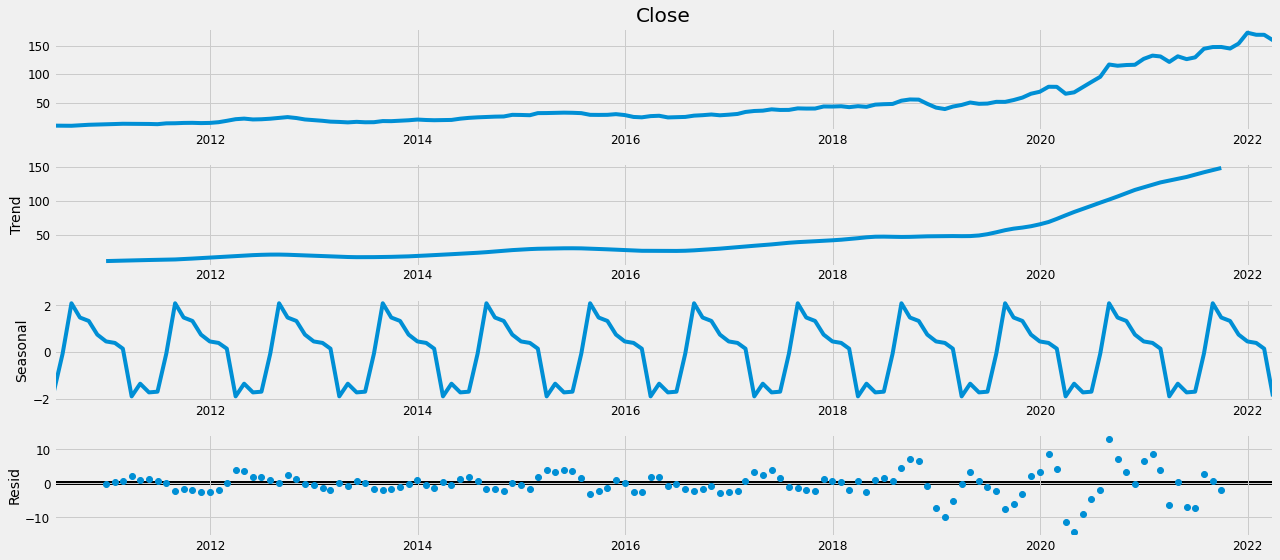

In [40]:
decomposition2 = sm.tsa.seasonal_decompose(monthly_mean2, model='additive')
fig = decomposition2.plot()
plt.show()

In [41]:
l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean2,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1568.557116199718
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1336.6064787941882
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1166.36142350536
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1026.8927548820477
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1047.9325238495162
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1033.3296573667842
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1022.5295931072228
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:983.5193195352185
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1379.8106951026962
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1170.6592207404524
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1011.8434000634176
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:905.9258892443598
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:928.9954234030087
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:904.207008581605
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:910.1726422085972
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:869.8658026615217
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:810.2074028511967
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:748.7990340558434
ARIM

In [42]:
print(l_results_aic)
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

[1568.557116199718, 1336.6064787941882, 1166.36142350536, 1026.8927548820477, 1047.9325238495162, 1033.3296573667842, 1022.5295931072228, 983.5193195352185, 1379.8106951026962, 1170.6592207404524, 1011.8434000634176, 905.9258892443598, 928.9954234030087, 904.207008581605, 910.1726422085972, 869.8658026615217, 810.2074028511967, 748.7990340558434, 779.1492204051249, 685.4561607057094, 750.4181507604264, 745.7789054111295, 684.71340404466, 681.8069709570271, 799.6250875487038, 741.0102413073517, 774.3452711664404, 680.579524515232, 748.6342039930936, 739.8111295996355, 684.7072263310661, 676.8579311417475, 802.9460077915937, 746.1430944006147, 785.7984112010984, 690.7472986562622, 745.0118914065904, 746.503285704287, 685.618449707923, 687.3500764767729, 797.6912695924555, 741.4042434271425, 780.5383301041245, 686.6302030995662, 745.2804371160935, 742.0358701845005, 686.1052858939264, 683.0578454362801, 804.2081632141671, 745.7344273354447, 779.4739489412443, 685.8476079049436, 743.757093

In [43]:
mod = sm.tsa.statespace.SARIMAX(monthly_mean2,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results2 = mod.fit()

print(results2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1486      0.077      1.936      0.053      -0.002       0.299
ar.S.L12      -0.6123      0.139     -4.395      0.000      -0.885      -0.339
ma.S.L12      -0.0571      0.155     -0.369      0.712      -0.361       0.246
sigma2        19.6483      1.693     11.604      0.000      16.330      22.967


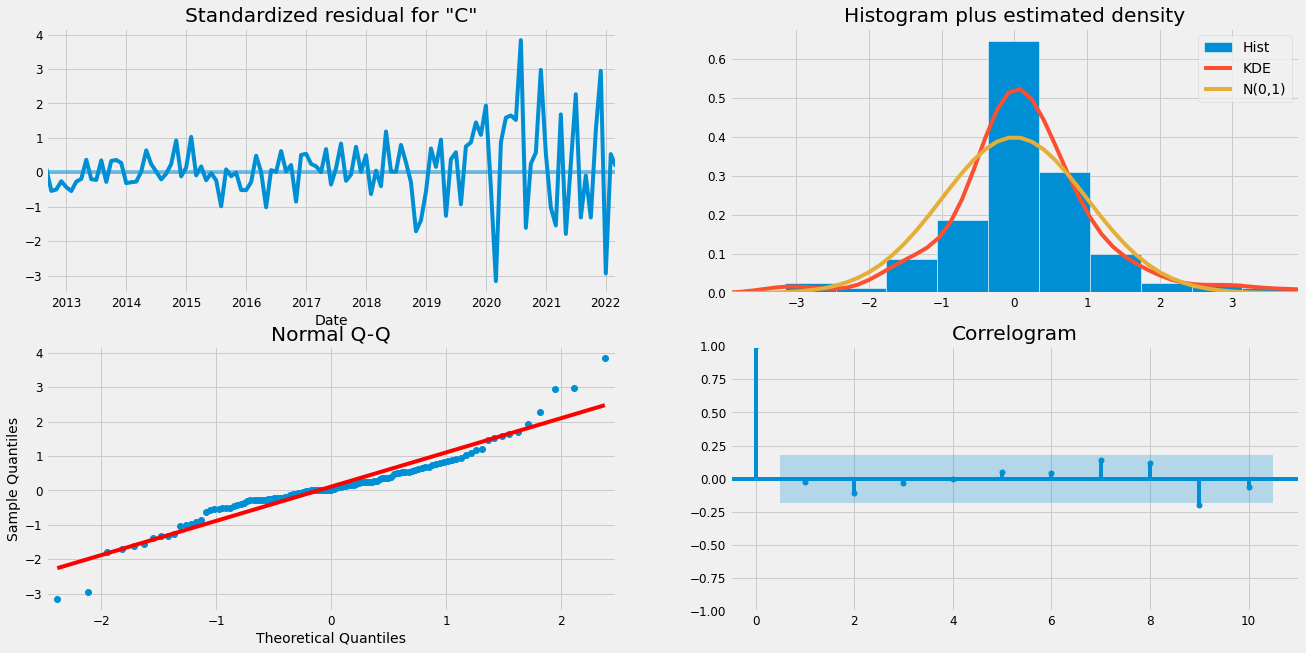

In [44]:
results2.plot_diagnostics(figsize=(20, 10))
plt.show()

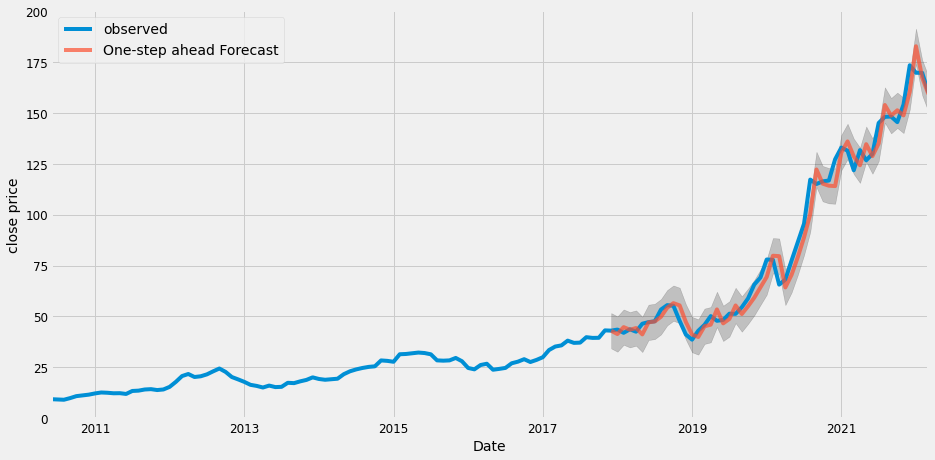

In [45]:
pred2 = results2.get_prediction(start=pd.to_datetime('2017-12-31'), dynamic=False) # prediction start date
pred_ci2 = pred2.conf_int()

ax = monthly_mean2['2010':].plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()
plt.show()

In [46]:
y_forecasted2 = pred2.predicted_mean
y_truth2 = monthly_mean2['2017-12-31':]

# Compute the mean square error
mse2 = ((y_forecasted2 - y_truth2) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse2, 2)))

The Mean Squared Error of our forecasts is 39.13


In [47]:
actual2=pd.DataFrame(monthly_mean2['2017-12-31':'2022-03-31'])

result2 = pd.concat([pred_ci2, actual2], axis=1).reindex(pred_ci2.index)
display(result2)

,lower Close,upper Close,Close
Date,,,
2017-12-31,34.226471,51.602114,42.972875
2018-01-31,32.610260,49.985903,43.501309
2018-02-28,36.018857,53.394500,41.909737
2018-03-31,34.726735,52.102378,43.624048
2018-04-30,35.557304,52.932947,42.458572
2018-05-31,32.438834,49.814477,46.384205
2018-06-30,38.368432,55.744075,47.155357
2018-07-31,38.805833,56.181476,47.577857
2018-08-31,41.120005,58.495648,53.336522


In [48]:
roy_ratio2=((pred_ci2['upper Close']+pred_ci2['lower Close'])/2 )/(pred_ci2['upper Close']-pred_ci2['lower Close'])
roy_ratio2 # predicted_mean/range of prediction=((upper+lower)/2)/upper-lower

Date
2017-12-31     2.469796
2018-01-31     2.376780
2018-02-28     2.572951
2018-03-31     2.498587
2018-04-30     2.546388
2018-05-31     2.366914
2018-06-30     2.708173
2018-07-31     2.733347
2018-08-31     2.866531
2018-09-30     3.121808
2018-10-31     3.251458
2018-11-30     3.188331
2018-12-31     2.718755
2019-01-31     2.361298
2019-02-28     2.294080
2019-03-31     2.596820
2019-04-30     2.642982
2019-05-31     3.074450
2019-06-30     2.679715
2019-07-31     2.804025
2019-08-31     3.186032
2019-09-30     2.944016
2019-10-31     3.163692
2019-11-30     3.407154
2019-12-31     3.701134
2020-01-31     3.993346
2020-02-29     4.594303
2020-03-31     4.582467
2020-04-30     3.697046
2020-05-31     4.055213
2020-06-30     4.554052
2020-07-31     5.111953
2020-08-31     5.771440
2020-09-30     7.036958
2020-10-31     6.635903
2020-11-30     6.577328
2020-12-31     6.566812
2021-01-31     7.516399
2021-02-28     7.830859
2021-03-31     7.407687
2021-04-30     7.156755
2021-05-31 